In [ ]:
!pip3 install pandas duckdb jinja2

# Основы анализа и проектирования баз данных

```
Контрольная точка: #1
Группа: 2ЭИТ1-9.24
Выполнил: Бирюков Николай
```

## ЭТАПЫ ВЫПОЛНЕНИЯ

## Этап №0  
#### Описание проекта (задания)

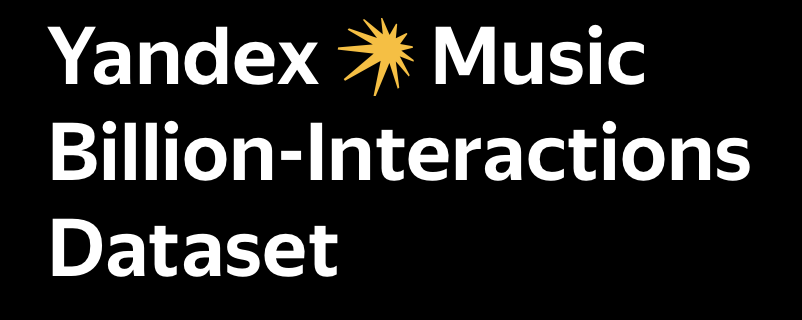


**Задачей настоящей работы** является произвести *"reverse engineering"* представляенного датасета, что так же является задачей по моделированию данных. Выбор темы был согласован с преподавателем.  

Моделирование данных будет проихводится не на основе интервью, а на основе уже существующих данных, что представляет большой интерес для исследования и продолжения этого курса во втором семестре, а так же имеет высокий потенциал для аналитической работы над предоставленными данными.

В ходе выполнения работы будет предпринята попытка отразить все 20 этапов работы.

**Yandex Music Billion-Interactions Dataset [(YaMBDa)](https://ya.ru/ai/papers/yandex-music-billion-interactions-dataset)**  — это [large-scale-датасет](https://huggingface.co/datasets/yandex/yambda) , построенный на логах [Яндекс Музыки](https://music.yandex.ru) — крупнейшего подписного стримингового сервиса в России (слушают 28 млн подписчиков Плюса в месяц, по данным на март 2025 года).  
Yandex считает, что у датасета есть потенциал стать стандартом для оценки [рекомендательных алгоритмов (RecSys)](https://ru.wikipedia.org/wiki/Рекомендательная_система), использующих машинное обучение, — как в индустрии, так и в академической среде.  

```
* Набор данных для обучения и оценки моделей машинного обучения, включающий миллионы объектов и приближённый по сложности к реальным условиям.
```

[Yambda (ArXiv)](https://arxiv.org/abs/2505.22238)  
[Dataset доступен на Hugging Face](https://huggingface.co/datasets/yandex/yambda)  


В датасете присутствуют несколько `parquet` файлов, связанных одним или более аттрибутов через файл с событиями (Events). На практике это представляет собой связь типа "звезда", которую далее мы попробуем представить в нормализованной форме.

```
Cite as:	arXiv:2505.22238 [cs.IR]  
 	(or arXiv:2505.22238v2 [cs.IR] for this version)  
```  
https://doi.org/10.48550/arXiv.2505.22238


## Этапы №1-3  
* #### В представленном описании предметной области и подсистем, определить информационные объекты. Совет, выделить их одним цветом;
* #### Выписать информационные объекты в виде маркированного списка, при этом если информационные объекты повторяются, дублировать их не нужно;
* #### Произвести (при возможности) объединение и преобразование информационных объектов в объекты. Представить результат в виде таблицы списка;

Попробуем выделить основные информационные объекты и их отношения друг с другом.

* <b>Пользователи системы (User / UID)</b>, которые слушают
* <b>Музыкальные Треки (Track / Item)</b> созданные
* <b>Артистами (Artist)</b> - один трек может принадлежать одному или нескольким артистам
* <b>Альбомы (Album)</b> - Группировка треков с привязкой к Артисту
* <b>События (Event)</b> - таблица фактов, которая связывает Пользователя и Трек в конкретный момент времени
* <b>Типы событий (Event Type)</b> - одно из нескольких типов взаимодействия Пользователя с системой

[Embedding - "звуковой портрет" музыкального трека, который содержит информацию сопоставимую с эмоциями человека от прослушивания трека. Позволяет сравнивать треки между собой.]: #

Мы не будем касаться некоторых объектов системы в виду того, что они не представлены в датасете, но по-прежнему достойны упоминания для представления читателю настоящей работы дополнительного контекста. Такие как:
* <b>Поток</b> - единичный объект (singleton) который представляет собой очередь из нескольких Треков, предлагаемых рекомендательными алгоритмами Пользователю к прослушиванию в текущий момент времени на основе множественных параметров, которые могут включать: историю лайков/дизлайков, время суток, локацию и прочие.
* <b>Поиск</b> - система полнотекстового поиска, которая предоставляет Пользователю возможность искать Треки на основе упомянутых строк из текста Трека, названия Трека, Артиста, Альбома и других факторов.
 

## Этап №4  
#### В представленном описании предметной области и подсистем, определить параметры для объектов. Совет, выделить их другим цветом;  

В виду того, что у нас нет описания предметной области в текстовом виде, давайте посмотрим какую информацию можно получить из `parquet` файлов с учетом их денормализованного вида. Релевантные параметры будут присутствовать в выводе, за исключением данных, не включенных в датасет.  
Будем считать что эти параметры являются полными, несмотря на то, что в реальной системе их должно быть больше.  

Для вывода этой информации выполним SQL запрос к каждому из `parquet` файлов с помощью библиотеки DuckDB:  
```
SELECT name, type, converted_type FROM parquet_schema(<file.parquet>);
```  

Это даст нам представление обо всех аттрибутах, с которыми предстоит работать.

In [11]:
# Load Dataset for local usage (~14Gb)  

import pandas as pd
import duckdb


remote_files = [
    "https://huggingface.co/datasets/yandex/yambda/resolve/main/album_item_mapping.parquet",
    "https://huggingface.co/datasets/yandex/yambda/resolve/main/artist_item_mapping.parquet",
    "https://huggingface.co/datasets/yandex/yambda/resolve/main/embeddings.parquet",
    "https://huggingface.co/datasets/yandex/yambda/resolve/main/flat/50m/dislikes.parquet",
    "https://huggingface.co/datasets/yandex/yambda/resolve/main/flat/50m/likes.parquet",
    "https://huggingface.co/datasets/yandex/yambda/resolve/main/flat/50m/listens.parquet",
    "https://huggingface.co/datasets/yandex/yambda/resolve/main/flat/50m/multi_event.parquet",
    "https://huggingface.co/datasets/yandex/yambda/resolve/main/flat/50m/undislikes.parquet",
    "https://huggingface.co/datasets/yandex/yambda/resolve/main/flat/50m/unlikes.parquet"
]

for file_path in remote_files:
    file_name = file_path.split("/")[-1]
    print(file_name)
    query = f"COPY (SELECT * FROM '{file_path}') TO 'var/data/{file_name}' (FORMAT PARQUET);"
    
    duckdb.sql(query)

album_item_mapping.parquet
artist_item_mapping.parquet
embeddings.parquet
dislikes.parquet
likes.parquet
listens.parquet
multi_event.parquet
undislikes.parquet
unlikes.parquet


In [2]:
import pandas as pd
import duckdb

local_files = [
    "var/data/album_item_mapping.parquet",
    "var/data/artist_item_mapping.parquet",
    "var/data/embeddings.parquet",
    "var/data/dislikes.parquet",
    "var/data/likes.parquet",
    "var/data/listens.parquet",
    "var/data/multi_event.parquet",
    "var/data/undislikes.parquet",
    "var/data/unlikes.parquet"
]

for file_path in local_files:
    query = f"SELECT name, type, converted_type FROM parquet_schema('{file_path}')"
    schema_info = duckdb.sql(query).df()
    
    print(file_path)
    
    # Print DataFrame without index 
    blankIndex=[''] * len(schema_info)
    schema_info.index=blankIndex
    display(schema_info)

var/data/album_item_mapping.parquet


,name,type,converted_type
,duckdb_schema,None,None
,album_id,INT32,UINT_32
,item_id,INT32,UINT_32


var/data/artist_item_mapping.parquet


,name,type,converted_type
,duckdb_schema,None,None
,artist_id,INT32,UINT_32
,item_id,INT32,UINT_32


var/data/embeddings.parquet


,name,type,converted_type
,duckdb_schema,None,None
,item_id,INT32,UINT_32
,embed,None,LIST
,list,None,None
,element,DOUBLE,None
,normalized_embed,None,LIST
,list,None,None
,element,DOUBLE,None


var/data/dislikes.parquet


,name,type,converted_type
,duckdb_schema,None,None
,uid,INT32,UINT_32
,timestamp,INT32,UINT_32
,item_id,INT32,UINT_32
,is_organic,INT32,UINT_8


var/data/likes.parquet


,name,type,converted_type
,duckdb_schema,None,None
,uid,INT32,UINT_32
,timestamp,INT32,UINT_32
,item_id,INT32,UINT_32
,is_organic,INT32,UINT_8


var/data/listens.parquet


,name,type,converted_type
,duckdb_schema,None,None
,uid,INT32,UINT_32
,timestamp,INT32,UINT_32
,item_id,INT32,UINT_32
,is_organic,INT32,UINT_8
,played_ratio_pct,INT32,UINT_16
,track_length_seconds,INT32,UINT_32


var/data/multi_event.parquet


,name,type,converted_type
,duckdb_schema,None,None
,uid,INT32,UINT_32
,timestamp,INT32,UINT_32
,item_id,INT32,UINT_32
,is_organic,INT32,UINT_8
,played_ratio_pct,INT32,UINT_16
,track_length_seconds,INT32,UINT_32
,event_type,BYTE_ARRAY,UTF8


var/data/undislikes.parquet


,name,type,converted_type
,duckdb_schema,None,None
,uid,INT32,UINT_32
,timestamp,INT32,UINT_32
,item_id,INT32,UINT_32
,is_organic,INT32,UINT_8


var/data/unlikes.parquet


,name,type,converted_type
,duckdb_schema,None,None
,uid,INT32,UINT_32
,timestamp,INT32,UINT_32
,item_id,INT32,UINT_32
,is_organic,INT32,UINT_8


#### Таким образом мы получили следующую картинку:  

<figure>
    <img src="static/pq_files.jpg"
         alt="Parquet files structure"
         width="326" height="356"> <!-- original size:  652 × 712 -->
    <figcaption>Диаграмма №1. Схема parquet файлов</figcaption>
</figure>

## Этап №5-6  
#### Каждому выявленному объекту необходимо сопоставить и дополнить остальные объекты максимальным количеством параметров, в виде таблицы;  
  
#### Далее необходимо произвести анализ полученных объектов и параметров и определить, какие объекты можно объединить, какие параметры являются не нужными для предметной области, для выявления сущностей и атрибутов;


На данном этапе давайте сопоставим полученные аттрибуты из `parquet` файлов с уже выявленными информационными объектами с Этапа №3.  

<html>
    <table>
        <tr>
            <td>
                <p style="color:Tomato"><b>Пользователи системы (User / UID)</b></p>
                <p style="color:DodgerBlue"><b>Музыкальные Треки (Track / Item)</b></p>
                <p style="color:MediumSeaGreen"><b>Артистами (Artist)</b></p>
                <p style="color:Gray"><b>Альбомы (Album)</b></p>
                <p style="color:SlateBlue"><b>Типы Событий (Event type)</b></p>
                <p style="color:DarkBlue"><b>События (Events)</b></p>
            </td>
            <td>
                <figure>
                    <img src="static/pq_files_colorcode.jpg"
                         alt="Parquet files structure"
                         width="326" height="356"> <!-- original size:  652 × 712 -->
                    <figcaption>Диаграмма №2. Привязка полей parquet файлов к информационным объектам</figcaption>
                </figure>
            </td>
        </tr>
</html>

## Этап №7  
#### Из полученного списка атрибутов у сущностей, необходимо выявить ключевой элемент данных (при возможности);

В нашем случае выделение ключевого элемента данных (РК) не составляет большого труда - это поля `parquet` файлов, у которых есть суффикс `id`:  

* User: `uid`
* Track: `item_id`
* Artist: `artist_id`
* Album: `album_id`
* Event type: не имеет PK, потому что с точки зрения 2НФ (?) было бы правильно использовать `event_type_id` как PK, тогда вторая колонка будет `event_type` и будет содержать 5 событий: listen, like, dislike, unlike, undislike.
* Event: это time-series данные, которые обычно не хранят в реляционных БД, но если приходится то стоит рассмотреть композитный PK из `timestamp` и `uid` и маловероятное добавление `item_id` в зависимости от задач.

## Этап №8-9   
#### Описание сущностей и атрибутов (этап № 7, без ключевых элементов данных).  
Красным цветом выделены, те атрибуты, которые повторяются;  

#### Подготовка ННФ. Описание атрибутов, на основании списка атрибутов  
(При этом, повторяющиеся атрибуты, которые относятся к одной и той же сущности
упраздняются);
«Приложение 1.xlsx». Лист «Этап 9».

| Сущность | Аттрибут | Описание |
|----------|-----------|----------|
| User | uid | уникальный идентификатор пользователя в системе |
| Track | item_id | уникальный идентификатор Трека в системе |
| | embed | эмбеддинг Трека с использованием СНН*|
| | normalized_embed | Нормализованный Эмбеддинг |
| | track_length_seconds | длина трека в секундах |
| Artist | artist_id | уникальный идентифиактор Артиста |
| Album | album_id | уникальный идентификатор Альбома |
| Event Type | event_type | Тип события: имеет 5 фиксированных значений |
| Event | timestamp | отметка времени, когда событие произошло |
| | is_organic | признак инициации события пользователем или рекомендательным алгоритмом |
| | played_ratio_pct | Время прослушивания Трека Пользователем |

\* СНН - Сверточные Нейронные Сети на основе Contrastive Learning of Musical Representations (J. Spijkervet et al., 2021)  


#### Важные особенности данных (взяты из описания датасета):  
* `event_type` может принимать значения: listen, like, dislike, unlike, undislike
* `is_organic` - Принимает значение `0` в случае инициации события рекомендательным алгоритмом, или `1` в случае действие Пользователя  
* `played_ratio_pct` и `track_length_seconds` являются NOT NULL только когда `event_type` = "listen"
* Все поля, кроме двух предыдущих, ганантированно NOT NULL
* Трек считается прослушанным ("listened"), если было проиграно более 50% его общей длительности
* `played_ratio_pct` может быть более 100% в случае если Пользователь перематывал трек и проигрывал некоторые секции по нескольку раз, что привело к превышению общего времени прослушивания над длиной Трека. Это ожидаемое поведение, не является ошибкой.
* Для каждого пользователя верно выражение len(item_ids) == len(timestamps) == len(is_organic)

##### Нормализация отношений – процесс приведения, не нормализованного отношения к «идеальному» виду, за счёт удаления повторяющейся информации и применения правил нормальных форм.  

Не нормализованная форма (NNF) – отношение, которое не соответствует ни одному правилу, ни одной нормальной форме.  

Нормализация процесс, каскадный – что бы перейти к следующему этапу нормализации, нужно выполнить предыдущие этапы.  

Виды нормальных форм:  

1. Нормальная форма (1 NF) – обязательный этап;  
2. Нормальная форма (2 NF) – обязательный этап;  
3. Нормальная форма (3 NF) – обязательный этап, чаще всего конечный этап, так как БД принимает классический и достаточный для оптимальной работы, с данными вид;  
4. Нормальная форма Бойса-Кодда (BCNF) – усиленная 3НФ, не обязательная к реализации;  
5. Нормальная форма (4 NF) – усиленная НФБК, не обязательная к реализации;  
6. Нормальная форма (5 NF) – теоретическая НФ, обладает правилами, которые улучшают БД, но усложняют работу с ней;  
7. Доменно-ключевая нормальная форма (DKNF) – теоретическая НФ, обладает правилами, которые улучшают БД, но усложняют работу с ней;  
8. Нормальная форма (6 NF) – теоретическая НФ, обладает правилами, которые улучшают БД, но усложняют работу с ней.  

## Этап №10  
#### Заполнение ННФ, минимум 5 записями;  
«Приложение 1.xlsx». Лист «Этап 10».


Для выполнения задачи 10го этапа нам потребуется просто прочитать данные из имеющихся `parquet` файлов и вывести первые 5 строк вместо заполнения Excel-таблицы.  Напишем для этого небольшой скрипт, который с помощью библиотеки DuckDB выполнит операцию  
```
SELECT * FROM <file.parquet> LIMIT 5;
```  
Можно считать эти данные денормализованными (NNF).  

In [3]:
import pandas as pd
import duckdb

for file_path in local_files:
    data_sample = duckdb.sql(f"SELECT * FROM '{file_path}' LIMIT 5").df()
    print(file_path)
    
    # Print DataFrame without index 
    blankIndex=[''] * len(data_sample)
    data_sample.index=blankIndex
    display(data_sample)

var/data/album_item_mapping.parquet


,album_id,item_id
,1,1491131
,1,5109849
,1,6735246
,2,2859065
,3,1859377


var/data/artist_item_mapping.parquet


,artist_id,item_id
,1,953587
,1,1921481
,1,2659068
,1,2740764
,1,6767564


var/data/embeddings.parquet


,item_id,embed,normalized_embed
,2,"[-1.5340346097946167, -0.3667665123939514, 3.2...","[-0.06463761062776703, -0.015453960991530893, ..."
,3,"[-3.7614669799804688, -1.0682544708251953, 3.3...","[-0.16393688999107472, -0.04655798298860864, 0..."
,4,"[2.445533037185669, -2.5236034393310547, 5.115...","[0.07627247358910043, -0.07870737125565455, 0...."
,5,"[0.8328456878662109, 0.11612524837255478, -0.6...","[0.03149010106338991, 0.004390724308883539, -0..."
,6,"[-2.431483030319214, -0.5687204003334045, -0.2...","[-0.10345024525108451, -0.024196864284124445, ..."


var/data/dislikes.parquet


,uid,timestamp,item_id,is_organic
,100,3087560,9170134,1
,100,3936560,8661238,1
,100,20432825,4927727,1
,400,2980800,399811,1
,400,3157520,1575108,1


var/data/likes.parquet


,uid,timestamp,item_id,is_organic
,100,44755,732449,1
,100,1155860,6568592,0
,100,1259125,5411243,1
,100,1260005,7371186,0
,100,1263935,4943655,0


var/data/listens.parquet


,uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds
,100,39420,8326270,0,100,170
,100,39420,1441281,0,100,105
,100,39625,286361,0,100,185
,100,40110,732449,0,100,240
,100,40360,3397170,0,46,130


var/data/multi_event.parquet


,uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds,event_type
,100,39420,8326270,0,100,170,listen
,100,39420,1441281,0,100,105,listen
,100,39625,286361,0,100,185,listen
,100,40110,732449,0,100,240,listen
,100,40360,3397170,0,46,130,listen


var/data/undislikes.parquet


,uid,timestamp,item_id,is_organic
,100,7895900,9170134,1
,100,7895900,5038504,1
,900,25364045,6092542,1
,900,25364045,6501913,1
,900,25364045,3628099,1


var/data/unlikes.parquet


,uid,timestamp,item_id,is_organic
,100,3087555,5038504,1
,100,3087555,9170134,1
,100,4012270,7833676,0
,100,21210445,7610592,0
,100,21210465,7610592,0


## Этап №11  
#### Создание 1НФ. Применение правил 1НФ;  
«Приложение 1.xlsx». Лист «Этап 11»;

##### Первая нормальная форма  

Отношение находится в первой нормальной форме, тогда и только тогда, когда выполняются следующие правила:  

1. Отсутствуют повторяющиеся строки – если в отношении встречаются две и более строки, которые на 100% одинаковые, их количество должно быть приведено к единичному экземпляру;
2. Поля приведены к неделимому значению – все «сложные» атрибуты, должны быть разделены на более «простые» атрибуты, исключениями являются:  дробные поля, поля даты и времени. Особенность – пустых кортежей быть не должно;
3. В столбце хранятся данные, одно типа и одного формата ввода – каждый столбец, должен хранить данные только одного типа данных и все данные, должны быть по своему виду максимально приведены к одной форме ввода;
4. В кортежах, отсутствуют массивы и списки любых видов – если в ННФ, в кортеже есть список, то в 1НФ, этот список разделяется на отдельные записи, при этом все остальные столбцы вне списка, остаются без изменений.

<em>Особенность:</em> Если в ННФ, встречается два и более столбца со списками, они не противоречат, свойству не избыточности данных, то при приведении такого отношения к 1НФ, нужно перечислить все возможные вариации между списками.

### Ответ на задание 11го этапа

В виду особенности нашего задания, можно сказать что представленные в `parquet` файлах данные частично соответствуют 1НФ исходя из условий задания:  
1. повторяющиеся строки - исходя из описания датасета, ни в одном из файлов нет повторяющихся строк  
2. данные имеют неделимые значения - это утсерждение так же верно, потому что датасет готов к исследованию с помощью алгоритмов машинного обучения и имеет сопутствующшие примеры кода и тесты к ним
3. В столбце хранятся данные одного типа и формата - верно
4. Отсутствуют массивы данных - это условие не выполняется в виду того, что embeddings это вектора, которые нельзя записать иначе как с помощью массивов. Для всех других полей это условие выполняется.

Менять данные в самих файлах смысла не имеет, но мы приведем их в нормальной форме на более поздних этапах настоящей работы  

## Этап №12-14  
#### Создание 2 НФ. Выписка сущностей и атрибутов в соответствии с этапом 7.  
Берётся целиком вся таблица. Выявленные ключевые элементы данных, будут являться первичными ключами, для организации межтабличной связи;  
#### Создание 2 НФ. Определение доступных ключевых элементов данных (Должны на 100% быть уникальными);  
«Приложение 1.xlsx». Лист «Этап 13».  
#### Скопировать этап 13 в этап 14.  
Приложение 2.xlsx. Лист «Этап 14».;

##### Вторая нормальная форма  

<em>Отношение находится во второй нормальной форме, тогда и только тогда, когда:</em>  
1. Отношение находится в первой нормальной форме – если хотя бы одно из правил 1 НФ не выполняется, то отношение не может быть приведено к 2 НФ;
2. В таблице должен быть первичный ключ – среди всех атрибутов должны быть определены те поля, которые позволят однозначно идентифицировать данные в не ключевых полях;
3. Все не ключевые атрибуты, зависят от полного первичного или составного ключа – необходимо произвести декомпозицию*  отношения.

Под декомпозицией понимается процесс – разбиения одного отношения, на более мелкие отношения, при этом у каждого из них, должен быть первичный ключ, определяющий, зависимые от него не ключевые поля.
Принцип декомпозиции:
1. Определить все первичные ключи (ключевые элементы данных);
2. Определить какие не ключевые атрибуты относятся к первичному ключу;
3. Вывести в отдельные отношения первичный ключ с его не ключевыми полями.

Важно понимать! При декомпозиции, количество записей во второй нормальной форме, хотя бы в одной из дочерних таблиц, должно совпадать с количеством записей в первой нормальной форме.

### Ответ на задание 12-14го этапа  

В полном объеме выполнен в ходе Этапа №7 а данные приведены на Этапе №10

Для улучшения наглядности утверждений о готовности, составим и отобразим ERD-диаграмму и далее будем ссылаться на нее. 

Где будут использованы следующие обозначения:  
* PK - первичный ключ, суррогатный ключ
* FK - внешний ключ

**Замечания:** 
* на диаграмме я сознательно не отображаю связь Альбома с Автором многие-ко-многим в виде отдельной joint-таблицы, в виду того что они уже связаны через таблицу с Треками, а прочее находится за пределами рассмотрения предметной области датасета.
* так же сознательно не продолжаю исследование предметной области путем работы с приложением Яндекс.Музыка чтобы установить дополнителные аттрибуты для Сущностей БД.  


<figure>
    <img src="static/erd.jpg"
         alt="Entity Relation Diagram"
         width="892" height="252"> <!-- original size:  892 × 252 -->
    <figcaption>Диаграмма №3. Информационные объекты и отношения между ними</figcaption>
</figure>

## Этап №15  
Реализация 3НФ.  
Приложение 2.xlsx. Лист «Этап 15»;

#### Таблица Пользователей

In [4]:
# data sampling script for USER

mevent_table = "var/data/multi_event.parquet"
sql_uid = f"""
    SELECT DISTINCT uid as user_id
    FROM '{mevent_table}'
    LIMIT 5;
    """
users = duckdb.sql(sql_uid).df()

# Print DataFrame without index 
blankIndex=[''] * len(users)
users.index=blankIndex
display(users)

,user_id
,16400
,59500
,59700
,61600
,89800


##### Таблица Артистов

In [5]:
# data sampling script for ARTIST

artist_table = "var/data/artist_item_mapping.parquet"
sql_artists = f"""
    SELECT DISTINCT artist_id 
    FROM '{artist_table}'
    LIMIT 5;
    """
artists = duckdb.sql(sql_artists).df()

# Print DataFrame without index 
blankIndex=[''] * len(artists)
artists.index=blankIndex
display(artists)

,artist_id
,89042
,89075
,89086
,89118
,89120


##### Таблица Альбомов

In [6]:
# data sampling script for ALBUM

album_table = "var/data/album_item_mapping.parquet"
sql_albums = f"""
    SELECT DISTINCT album_id 
    FROM '{album_table}'
    LIMIT 5;
    """
albums = duckdb.sql(sql_albums).df()

# Print DataFrame without index 
blankIndex=[''] * len(albums)
albums.index=blankIndex
display(albums)

,album_id
,258655
,258746
,258785
,258854
,258906


##### Таблица Треков

In [7]:
# data sampling script for TRACK (item)

embed_file = "var/data/embeddings.parquet"
artist_file = "var/data/artist_item_mapping.parquet"
album_file = "var/data/album_item_mapping.parquet"
mevent_file = "var/data/multi_event.parquet"
sql_tracks = f"""
    SELECT
        mev.item_id as track_id,
        mev.track_length_seconds,
        e.embed,
        e.normalized_embed,
        art.artist_id,
        alb.album_id
FROM '{mevent_file}' AS mev
LEFT JOIN '{embed_file}' AS e
    ON mev.item_id = e.item_id
LEFT JOIN '{artist_file}' AS art
    ON mev.item_id = art.item_id
LEFT JOIN '{album_file}' AS alb
    ON mev.item_id = alb.item_id
LIMIT 5;
"""
tracks = duckdb.sql(sql_tracks).df()

# Print DataFrame without index 
blankIndex=[''] * len(tracks)
tracks.index=blankIndex
display(tracks)

,track_id,track_length_seconds,embed,normalized_embed,artist_id,album_id
,2285747,250,"[-6.492494106292725, -1.100144863128662, 1.102...","[-0.18112681860316898, -0.03069170888703293, 0...",60057,1177406
,9076810,215,"[-5.31264591217041, 0.7434121966362, 0.9905246...","[-0.17382728531996522, 0.024324098792089372, 0...",1053188,2048109
,2873638,<NA>,"[-3.9686813354492188, 1.6214475631713867, 3.91...","[-0.1285067852695834, 0.052502833111131963, 0....",354689,3508
,2873638,200,"[-3.9686813354492188, 1.6214475631713867, 3.91...","[-0.1285067852695834, 0.052502833111131963, 0....",354689,3508
,2498547,200,"[-0.6470407247543335, 1.2672646045684814, 2.10...","[-0.028521492834865873, 0.05586090172732517, 0...",815321,2574737


##### Таблица Типов Событий 

In [8]:
# data sampling script for EVENT TYPES

event_types = {
    "0": ["1", "listen"],
    "1": ["2", "like"],
    "2": ["3", "unlike"],
    "3": ["4", "dislike"],
    "4": ["5", "undislike"]
}

event_type = pd.DataFrame.from_dict(event_types, orient="index", columns=["event_type_id", "event_type"] )

# Print DataFrame without index 
blankIndex=[''] * len(event_type)
event_type.index=blankIndex
display(event_type)

,event_type_id,event_type
,1,listen
,2,like
,3,unlike
,4,dislike
,5,undislike


##### Таблица Событий 

In [10]:
# data sampling script for EVENT

mevent_file = "var/data/multi_event.parquet"

sql_events = f"""   
    CREATE SEQUENCE 'serial';
    
    SELECT
        nextval('serial') as event_id,  -- SEQUENCE OBJECT
        mev.uid as user_id,
        mev.item_id as track_id,
        mev.track_length_seconds,
        mev.timestamp,
        mev.is_organic,
        mev.played_ratio_pct,
FROM '{mevent_file}' AS mev
LIMIT 5;
"""
events = duckdb.sql(sql_events).df()

# Print DataFrame without index 
blankIndex=[''] * len(events)
events.index=blankIndex
display(events)

,event_id,user_id,track_id,track_length_seconds,timestamp,is_organic,played_ratio_pct
,1,100,8326270,170,39420,0,100
,2,100,1441281,105,39420,0,100
,3,100,286361,185,39625,0,100
,4,100,732449,240,40110,0,100
,5,100,3397170,130,40360,0,46


## Этап №16  
Разработка родительских таблиц инфологической модели данных;

## Этап №17  
Разработка дочерних таблиц инфологической модели данных со связями 1:М;

## Этап №18  
Разработка дочерних таблиц инфологической модели данных со связями М:М;

## Этап №19  
На основании инфологической модели данных, произвести разработку словаря данных;

## Этап №20  
На основании словаря данных, произвести разработку даталогической модели данных;

<figure>
    <img src="static/19.jpg"
         alt="Датологическая модель данных"
         <!-- width="1213" height="253" original size:  1213 × 253 -->
    <figcaption>Диаграмма №4. Датологическая модель данных</figcaption>
</figure>